In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def extract_data_from_file(log_file, output_file):
    # Read the log data from the file
    with open(log_file, 'r') as file:
        log_data = file.read()

    # Define regex to match the relevant entries
    pattern = re.compile(
        r"\[(.*?)\] .*? \| fwd: ([\d.]+) \| bwd: ([\d.]+) \| bwd_inner: ([\d.]+) \| bwd_allreduce: ([\d.]+) \| step: ([\d.]+)"
    )

    # Extract matches
    matches = pattern.findall(log_data)

    # Organize into a DataFrame
    columns = ["timestamp", "fwd", "bwd", "bwd_inner", "bwd_allreduce", "step"]
    data = pd.DataFrame(matches, columns=columns)

    # Convert numeric columns to float
    numeric_columns = ["fwd", "bwd", "bwd_inner", "bwd_allreduce", "step"]
    data[numeric_columns] = data[numeric_columns].astype(float)

    # Save the DataFrame to a CSV file
    data.to_csv(output_file, index=False)

    print(f"Data successfully saved to {output_file}")

In [ ]:
log_file = "output_resnet50_exp4_bw_v1.log"
output_file = "log_data_resnet50_exp4.csv"
extract_data_from_file(log_file, output_file)


Data successfully saved to log_data_resnet50_exp4.csv


In [50]:
# Function to calculate combined metrics, plot, and compute improvements
def process_and_plot_combined(filepaths, labels, output_plot_prefix):
    # Initialize storage for aggregated stats
    stats = {'Computation Time': {'mean': [], 'min': [], 'max': []},
             'Communication Time': {'mean': [], 'min': [], 'max': []},
             'Total Step Time': {'mean': [], 'min': [], 'max': []}}

    # Process each file
    for filepath in filepaths:
        # Read the CSV and exclude the first entry (warm-up)
        df = pd.read_csv(filepath).iloc[1:]

        # Calculate combined metrics
        df['Computation Time'] = df['fwd'] + df['bwd'] + df['bwd_inner']
        df['Communication Time'] = df['bwd_allreduce']
        df['Total Step Time'] = df['Computation Time'] + df['Communication Time'] + df['step']

        # Calculate stats for each combined metric
        for metric in stats.keys():
            stats[metric]['mean'].append(df[metric].mean())
            stats[metric]['min'].append(df[metric].min())
            stats[metric]['max'].append(df[metric].max())

    # Print percentage improvement
    print("\nPercentage Improvements (relative to Baseline):")
    for metric in stats.keys():
        print(f"\nMetric: {metric}")
        baseline_mean = stats[metric]['mean'][0]  # Baseline is experiment 0
        for i in range(1, len(filepaths)):  # Compare with other experiments
            improvement = ((baseline_mean - stats[metric]['mean'][i]) / baseline_mean) * 100
            print(f"Experiment {i} ({labels[i]}): {improvement:.2f}% improvement")

    # Plot combined metrics
    for metric, values in stats.items():
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            x=range(len(labels)),
            y=values['mean'],
            yerr=[
                [m - mn for m, mn in zip(values['mean'], values['min'])],
                [mx - m for m, mx in zip(values['mean'], values['max'])]
            ],
            fmt='o',
            capsize=5,
            label=f"{metric} (mean with min/max)"
        )
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.title(f"{metric} Across Experiments (Excluding Warm-Up)")
        plt.xlabel("Experiment")
        plt.ylabel(f"{metric} (ms)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_plot_prefix}_{metric}.png")
        plt.show()


Percentage Improvements (relative to Baseline):

Metric: Computation Time
Experiment 1 (FP16 + Compression): 71.17% improvement
Experiment 2 (Compression): 72.60% improvement

Metric: Communication Time
Experiment 1 (FP16 + Compression): -1.20% improvement
Experiment 2 (Compression): 31.07% improvement

Metric: Total Step Time
Experiment 1 (FP16 + Compression): 51.98% improvement
Experiment 2 (Compression): 69.23% improvement


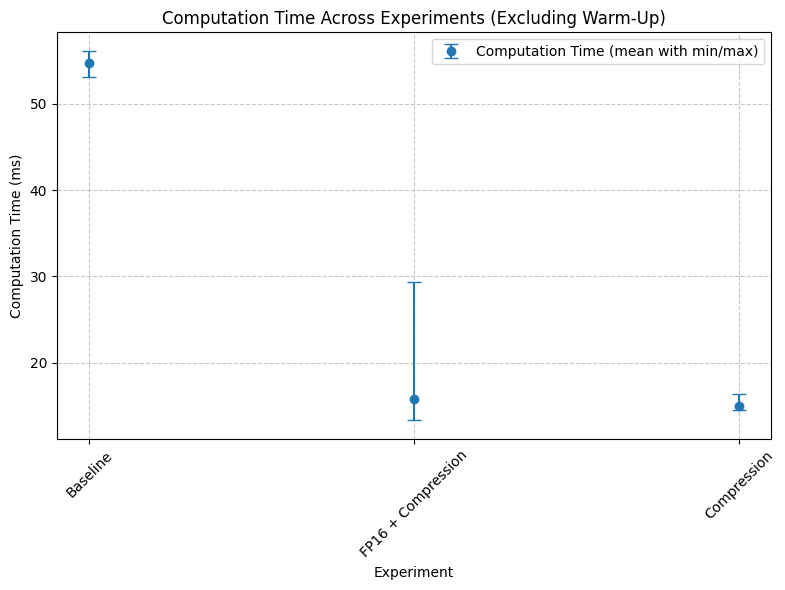

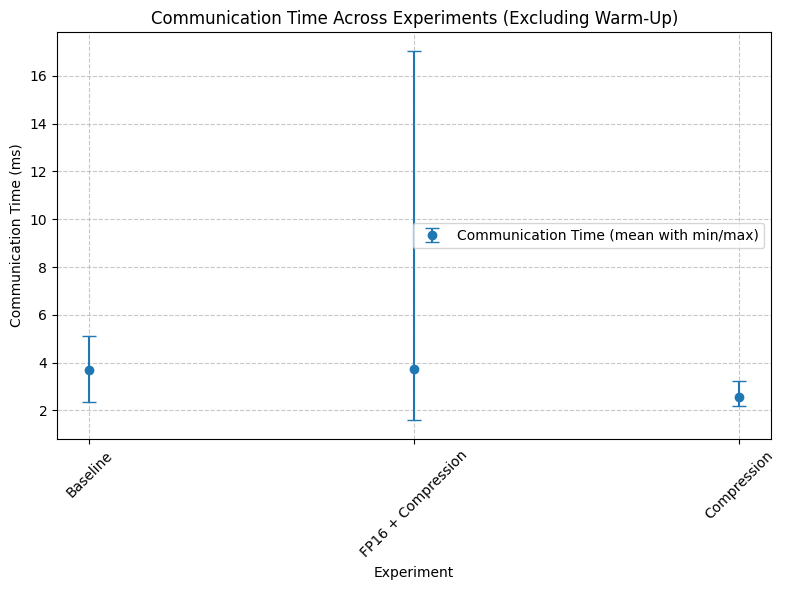

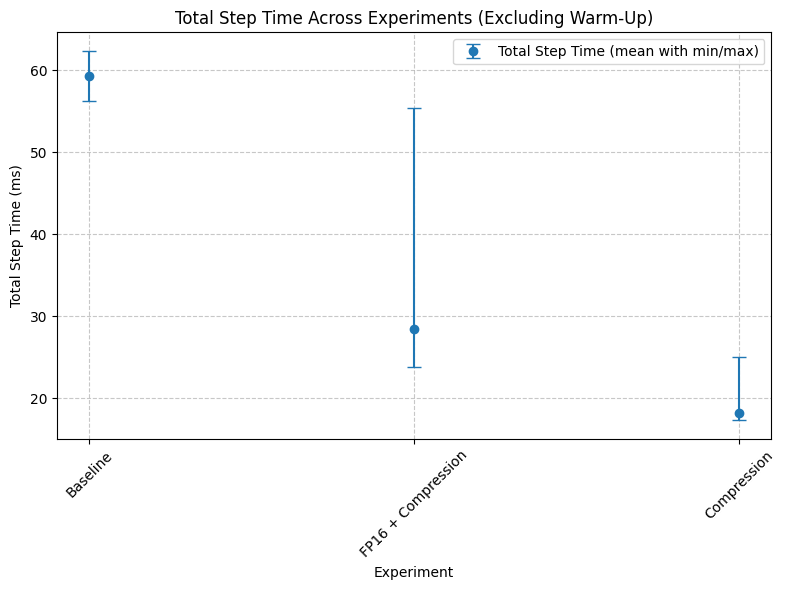

In [51]:
# File paths to the CSV files
filepaths = ["log_data_exp0.csv", "log_data_exp1.csv", "log_data_exp2.csv"]


# Labels for experiments
labels = ["Baseline", "FP16 + Compression", "Compression"]

# Process and plot combined metrics
process_and_plot_combined(filepaths, labels, "resnet18_combined_excluding_warmup")


Percentage Improvements (relative to Baseline):

Metric: Computation Time
Experiment 1 (FP16 + Compression): 0.18% improvement
Experiment 2 (Compression): 5.51% improvement

Metric: Communication Time
Experiment 1 (FP16 + Compression): -73.53% improvement
Experiment 2 (Compression): 55.82% improvement

Metric: Total Step Time
Experiment 1 (FP16 + Compression): -25.84% improvement
Experiment 2 (Compression): 9.75% improvement


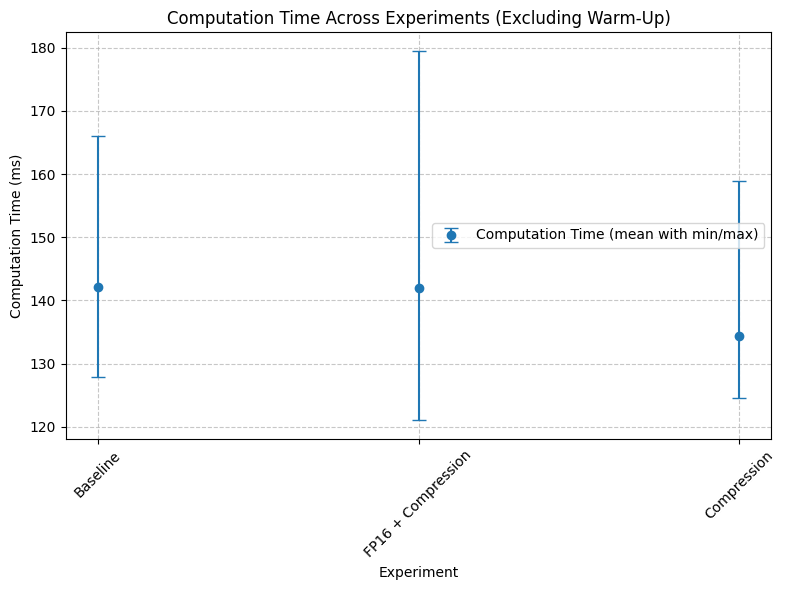

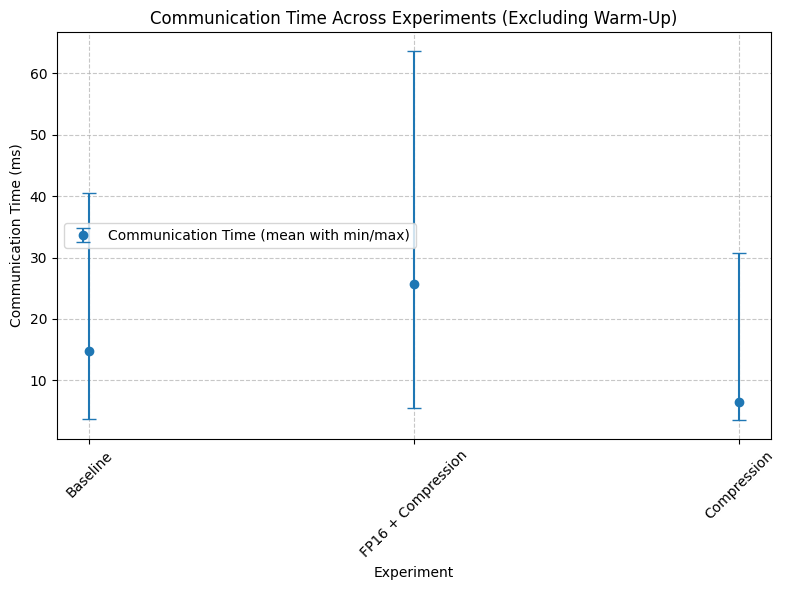

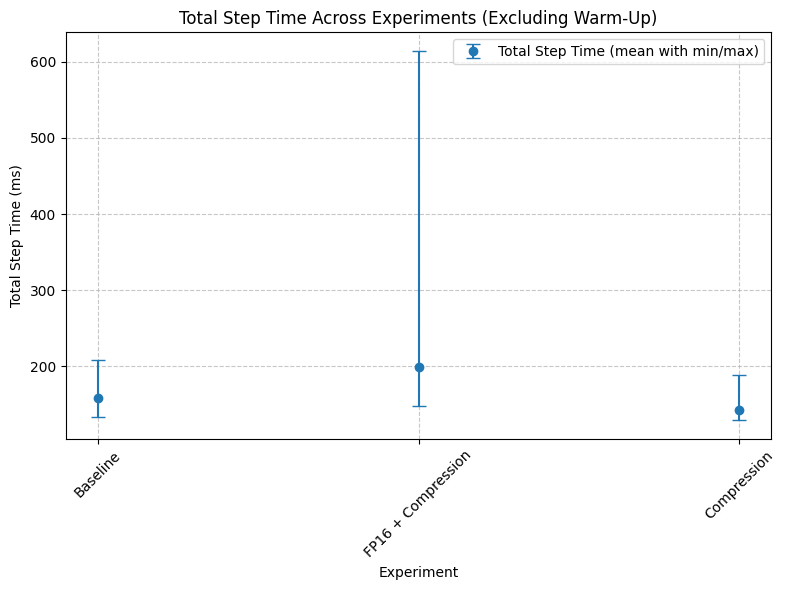

In [53]:
# File paths to the CSV files
filepaths = ["log_data_resnet50_exp0.csv", "log_data_resnet50_exp1.csv", "log_data_resnet50_exp2.csv"]


# Labels for experiments
labels = ["Baseline", "FP16 + Compression", "Compression"]

# Process and plot combined metrics
process_and_plot_combined(filepaths, labels, "resnet50_combined_excluding_warmup")

In [57]:
from tabulate import tabulate

def create_comparison_table(filepaths, labels):
    # Initialize data storage for the table
    table_data = {
        "Metric": ["Computation Time", "Communication Time", "Total Step Time"],
        labels[0]: [],
        labels[1]: [],
        f"Improvement {labels[1]} vs {labels[0]} (%)": [],
        labels[2]: [],
        f"Improvement {labels[2]} vs {labels[0]} (%)": []
    }

    # Read and process each file
    all_stats = []
    for filepath in filepaths:
        # Read the CSV and exclude the first entry (warm-up)
        df = pd.read_csv(filepath).iloc[1:]

        # Calculate combined metrics
        df['Computation Time'] = df['fwd'] + df['bwd'] + df['bwd_inner']
        df['Communication Time'] = df['bwd_allreduce']
        df['Total Step Time'] = df['Computation Time'] + df['Communication Time'] + df['step']

        # Calculate mean values for each metric
        all_stats.append({
            "Computation Time": df['Computation Time'].mean(),
            "Communication Time": df['Communication Time'].mean(),
            "Total Step Time": df['Total Step Time'].mean()
        })

    # Fill the table data
    baseline_stats = all_stats[0]
    for metric in table_data["Metric"]:
        table_data[labels[0]].append(baseline_stats[metric])
        for i in range(1, len(filepaths)):  # For experiments 1 and 2
            exp_stats = all_stats[i][metric]
            table_data[labels[i]].append(exp_stats)
            improvement = ((baseline_stats[metric] - exp_stats) / baseline_stats[metric]) * 100
            table_data[f"Improvement {labels[i]} vs {labels[0]} (%)"].append(improvement)

    # Convert to DataFrame for manipulation
    table_df = pd.DataFrame(table_data)

    # Pretty print using tabulate and return as string
    return tabulate(table_df, headers='keys', tablefmt='pretty', showindex=False)


In [58]:
# File paths to the CSV files
filepaths = ["log_data_exp0.csv", "log_data_exp1.csv", "log_data_exp2.csv"]

# Labels for experiments
labels = ["Baseline", "FP16 + Compression", "Compression"]

# Generate the table
pretty_table = create_comparison_table(filepaths, labels)

# Print the table wherever needed
print(pretty_table)

+--------------------+--------------------+--------------------+------------------------------------------------+--------------------+-----------------------------------------+
|       Metric       |      Baseline      | FP16 + Compression | Improvement FP16 + Compression vs Baseline (%) |    Compression     | Improvement Compression vs Baseline (%) |
+--------------------+--------------------+--------------------+------------------------------------------------+--------------------+-----------------------------------------+
|  Computation Time  |     54.670625      | 15.760153846153848 |               71.17253763578914                | 14.977076923076924 |            72.6048917072433             |
| Communication Time | 3.6981250000000006 | 3.7425641025641023 |               -1.201665778309326               | 2.5491794871794875 |            31.06832551145548            |
|  Total Step Time   | 59.30666666666667  | 28.48051282051282  |               51.97755257332596                | 1

In [59]:
# File paths to the CSV files
filepaths = ["log_data_resnet50_exp0.csv", "log_data_resnet50_exp1.csv", "log_data_resnet50_exp2.csv"]

# Labels for experiments
labels = ["Baseline", "FP16 + Compression", "Compression"]

# Generate the table
pretty_table = create_comparison_table(filepaths, labels)

# Print the table wherever needed
print(pretty_table)

+--------------------+--------------------+--------------------+------------------------------------------------+--------------------+-----------------------------------------+
|       Metric       |      Baseline      | FP16 + Compression | Improvement FP16 + Compression vs Baseline (%) |    Compression     | Improvement Compression vs Baseline (%) |
+--------------------+--------------------+--------------------+------------------------------------------------+--------------------+-----------------------------------------+
|  Computation Time  | 142.16208333333333 | 141.91145833333334 |               0.1762952498468487               | 134.32354166666667 |            5.513806130912772            |
| Communication Time | 14.762499999999998 | 25.61729166666667  |               -73.52949477843642               | 6.5214583333333325 |            55.82416031611628            |
|  Total Step Time   |     158.600625     | 199.58479166666666 |               -25.84111296324756               | 1

In [62]:

# Function to calculate combined metrics, plot, and compute improvements
def process_and_plot_combined_single_plot(filepaths, labels, output_plot_prefix):
    # Initialize storage for aggregated stats
    stats = {'Computation Time': {'mean': [], 'min': [], 'max': []},
             'Communication Time': {'mean': [], 'min': [], 'max': []},
             'Total Step Time': {'mean': [], 'min': [], 'max': []}}

    # Process each file
    for filepath in filepaths:
        # Read the CSV and exclude the first entry (warm-up)
        df = pd.read_csv(filepath).iloc[1:]

        # Calculate combined metrics
        df['Computation Time'] = df['fwd'] + df['bwd'] + df['bwd_inner']
        df['Communication Time'] = df['bwd_allreduce']
        df['Total Step Time'] = df['Computation Time'] + df['Communication Time'] + df['step']

        # Calculate stats for each combined metric
        for metric in stats.keys():
            stats[metric]['mean'].append(df[metric].mean())
            stats[metric]['min'].append(df[metric].min())
            stats[metric]['max'].append(df[metric].max())

    # Combine all metrics into a single plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # X-axis positions for grouped metrics
    x_labels = ["Comp. Time (Exp0)", "Comp. Time (Exp1)", "Comp. Time (Exp2)",
                "Comm. Time (Exp0)", "Comm. Time (Exp1)", "Comm. Time (Exp2)",
                "Total Step Time (Exp0)", "Total Step Time (Exp1)", "Total Step Time (Exp2)"]
    x_positions = range(len(x_labels))

    # Flatten data for plotting
    mean_values = []
    yerr_lower = []
    yerr_upper = []

    for metric, values in stats.items():
        for i in range(len(labels)):
            mean_values.append(values['mean'][i])
            yerr_lower.append(values['mean'][i] - values['min'][i])
            yerr_upper.append(values['max'][i] - values['mean'][i])

    # Error bars
    ax.errorbar(x_positions, mean_values, yerr=[yerr_lower, yerr_upper], fmt='o', capsize=5, label="Mean with Min/Max")

    # Customizing the plot
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_title("Metrics Across Experiments (Excluding Warm-Up)")
    ax.set_xlabel("Metrics and Experiments")
    ax.set_ylabel("Time (ms)")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f"{output_plot_prefix}_combined_metrics.png")
    plt.show()

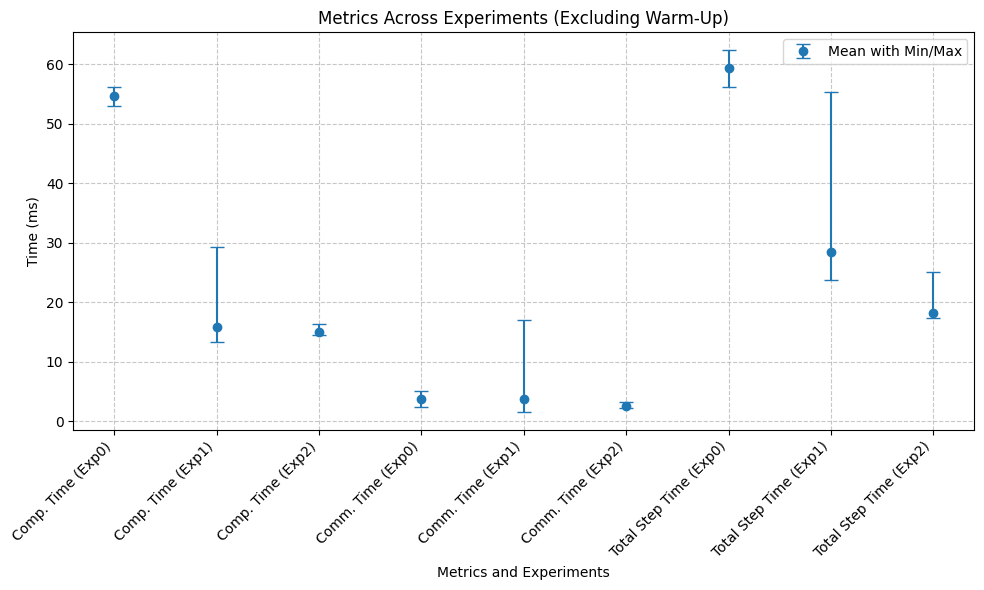

In [63]:
# File paths to the CSV files
filepaths = ["log_data_exp0.csv", "log_data_exp1.csv", "log_data_exp2.csv"]

# Labels for experiments
labels = ["Baseline", "FP16 + Compression", "Compression"]

# Process and create the single combined plot
process_and_plot_combined_single_plot(filepaths, labels, "resnet18_combined")
